In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import time
import requests
import warnings

warnings.filterwarnings('ignore')

In [15]:
class MarketData:
    def __init__(self, ticker, start_date, end_date=None):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.datetime.today().strftime('%Y-%m-%d')
        self.data = None
        self.log_returns = None
        self.daily_volatility = None
        self.adv = None  # Average Daily Volume

    def fetch_data(self):
        # Fetch historical data
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        if self.data.empty:
            raise ValueError(f"No data fetched for ticker {self.ticker}.")
        print(f"Data fetched for {self.ticker} from {self.start_date} to {self.end_date}.")

    def fetch_intraday_data(self, interval='1m'):
        # Fetch intraday data using yfinance
        intraday_data = yf.download(tickers=self.ticker, period='5d', interval=interval)
        if intraday_data.empty:
            raise ValueError(f"No intraday data fetched for ticker {self.ticker}.")
        self.intraday_data = intraday_data
        print(f"Intraday data fetched for {self.ticker}.")

    def calculate_intraday_volume_profile(self):
        # Calculate average volume per time interval
        self.intraday_data['Time'] = self.intraday_data.index.time
        volume_profile = self.intraday_data.groupby('Time')['Volume'].mean()
        self.volume_profile = volume_profile / volume_profile.sum()  # Normalize
        print("Intraday volume profile calculated.")

    def calculate_log_returns(self):
        # Calculate daily logarithmic returns
        self.data['Log_Returns'] = np.log(self.data['Adj Close'] / self.data['Adj Close'].shift(1))
        self.data.dropna(inplace=True)
        self.log_returns = self.data['Log_Returns']

    def estimate_volatility(self):
        # Calculate daily volatility
        self.daily_volatility = self.log_returns.std()
        print(f"Estimated daily volatility (sigma) for {self.ticker}: {self.daily_volatility:.6f}")

    def calculate_adv(self):
        # Calculate Average Daily Volume over the past month
        self.adv = self.data['Volume'][-21:].mean()
        print(f"Estimated Average Daily Volume (ADV) for {self.ticker}: {self.adv:,.0f}")

    def prepare_data(self):
        self.fetch_data()
        self.calculate_log_returns()
        self.estimate_volatility()
        self.calculate_adv()

In [17]:
class ParameterEstimator:
    def __init__(self, market_data):
        self.market_data = market_data
        self.sigma = None
        self.S0 = None
        self.X0 = None  # Total shares to trade
        self.T = None   # Trading horizon
        self.N = None   # Number of time steps
        self.dt = None  # Time step size
        self.phi = None
        self.eta = None
        self.epsilon = None

    def estimate_parameters(self, X0, T, N, phi, eta=None, epsilon=0.0):
        self.sigma = self.market_data.daily_volatility
        self.S0 = self.market_data.data['Adj Close'][-1]
        self.X0 = X0
        self.T = T
        self.N = N
        self.dt = T / N
        self.phi = phi
        self.epsilon = epsilon

        # Estimate eta if not provided
        if eta is None:
            # Simple estimation of eta using empirical formula
            self.eta = self.S0 / (self.market_data.adv * np.sqrt(self.N))
            print(f"Estimated temporary impact coefficient (eta): {self.eta:.6e}")
        else:
            self.eta = eta

        print(f"Parameters estimated for {self.market_data.ticker}:")
        print(f"  Sigma (volatility): {self.sigma:.6f}")
        print(f"  Initial price (S0): ${self.S0:.2f}")
        print(f"  Total shares to trade (X0): {self.X0}")
        print(f"  Trading horizon (T): {self.T} days")
        print(f"  Time steps (N): {self.N}")
        print(f"  Time step size (dt): {self.dt:.6f}")
        print(f"  Risk aversion (phi): {self.phi}")
        print(f"  Temporary impact coefficient (eta): {self.eta:.6e}")
        print(f"  Permanent impact coefficient (epsilon): {self.epsilon}")


In [19]:
class OptimalExecutionModel:
    def __init__(self, params):
        self.params = params
        self.kappa = None
        self.x_t = None
        self.u_t = None
        self.t_grid = None

    def calculate_kappa(self):
        self.kappa = np.sqrt(self.params.phi * self.params.sigma**2 / self.params.eta)
        print(f"Calculated kappa: {self.kappa:.6e}")

    def calculate_optimal_trajectory(self):
        self.t_grid = np.linspace(0, self.params.T, self.params.N + 1)
        sinh_kappa_T = np.sinh(self.kappa * self.params.T)
        self.x_t = self.params.X0 * (np.sinh(self.kappa * (self.params.T - self.t_grid)) / sinh_kappa_T)
        self.u_t = -np.diff(self.x_t) / self.params.dt  # Trading rate
        print("Optimal execution trajectory calculated.")

    def adjust_for_volume_profile(self, volume_profile):
        volume_profile_array = volume_profile.values
    
        # Resample volume_profile_array to match the length of self.u_t
        from scipy.interpolate import interp1d
    
        original_length = len(volume_profile_array)
        target_length = len(self.u_t)
    
        # Create interpolation function
        interpolation_function = interp1d(
            np.linspace(0, 1, original_length),
            volume_profile_array,
            kind='linear',
            fill_value='extrapolate'
        )
    
        # Generate new volume profile array with the target length
        volume_profile_array_resampled = interpolation_function(np.linspace(0, 1, target_length))
    
        # Normalize the resampled volume profile
        volume_profile_array_resampled /= np.mean(volume_profile_array_resampled)
    
        print(f"Length of resampled volume_profile_array: {len(volume_profile_array_resampled)}")
        print(f"Length of self.u_t: {len(self.u_t)}")
    
        # Adjust self.u_t
        self.u_t = self.u_t * volume_profile_array_resampled
        self.x_t = np.concatenate(([self.params.X0], self.params.X0 - np.cumsum(self.u_t * self.params.dt)))
        print("Trading trajectory adjusted for intraday volume profile.")

    def run_model(self):
        self.calculate_kappa()
        self.calculate_optimal_trajectory()


In [21]:
class SimulationEngine:
    def __init__(self, market_data, model):
        self.market_data = market_data
        self.model = model

    def simulate_price_paths(self, num_paths=1):
        dt = self.model.params.dt
        N = self.model.params.N
        S0 = self.model.params.S0
        sigma = self.model.params.sigma

        dW = np.random.randn(num_paths, N) * np.sqrt(dt)
        price_paths = np.zeros((num_paths, N + 1))
        price_paths[:, 0] = S0
        for i in range(N):
            price_paths[:, i + 1] = price_paths[:, i] * np.exp(-0.5 * sigma**2 * dt + sigma * dW[:, i])
        return price_paths

    def calculate_execution_cost(self, price_paths, gamma=1.0):
        num_paths = price_paths.shape[0]
        N = self.model.params.N
        dt = self.model.params.dt
        u_t = self.model.u_t
        x_t = self.model.x_t
        eta = self.model.params.eta
        epsilon = self.model.params.epsilon

        execution_costs = np.zeros(num_paths)

        for j in range(num_paths):
            execution_cost = 0.0
            for i in range(N):
                # Nonlinear market impact
                temp_impact = eta * (abs(u_t[i]) / self.market_data.adv) ** gamma
                S_exec = price_paths[j, i] + temp_impact * np.sign(u_t[i]) + epsilon * x_t[i]
                execution_cost += u_t[i] * S_exec * dt
            execution_costs[j] = execution_cost

        return execution_costs


In [23]:
def main():
    # User inputs
    ticker_symbol = input("Enter the ticker symbol (e.g., AAPL): ").upper()
    start_date = input("Enter the start date for historical data (YYYY-MM-DD): ")
    end_date = input("Enter the end date for historical data (YYYY-MM-DD) or press Enter for today: ") or None

    # Initialize MarketData
    market_data = MarketData(ticker_symbol, start_date, end_date)
    market_data.prepare_data()

    # Initialize ParameterEstimator
    estimator = ParameterEstimator(market_data)

    # User inputs for parameters
    X0 = int(input("Enter the total shares to trade (e.g., 1000000): "))
    T = float(input("Enter the trading horizon in days (e.g., 1.0): "))
    N = int(input("Enter the number of time steps (e.g., 390 for intraday): "))
    phi = float(input("Enter the risk aversion parameter (e.g., 1e-6): "))
    gamma_input = input("Enter the market impact exponent gamma (e.g., 0.5 for nonlinear impact) or press Enter for linear impact: ")
    gamma = float(gamma_input) if gamma_input else 1.0
    eta_input = input("Enter the temporary impact coefficient eta or press Enter to estimate: ")
    eta = float(eta_input) if eta_input else None

    # Estimate parameters
    estimator.estimate_parameters(X0=X0, T=T, N=N, phi=phi, eta=eta)

    # Initialize OptimalExecutionModel
    model = OptimalExecutionModel(estimator)
    model.run_model()

    if N > 390:
        market_data.fetch_intraday_data(interval='1m')
        market_data.calculate_intraday_volume_profile()
        model.adjust_for_volume_profile(market_data.volume_profile)

    # Initialize SimulationEngine
    simulator = SimulationEngine(market_data, model)

    # Simulate price paths
    num_paths = int(input("Enter the number of simulation paths (e.g., 1000): "))
    price_paths = simulator.simulate_price_paths(num_paths=num_paths)

    # Calculate execution costs
    execution_costs = simulator.calculate_execution_cost(price_paths)

    # Analyze and display results
    mean_cost = np.mean(execution_costs)
    std_cost = np.std(execution_costs)

    print(f"\nAverage Execution Cost over {num_paths} simulations: ${mean_cost:,.2f}")
    print(f"Standard Deviation of Execution Cost: ${std_cost:,.2f}")

    # Plot distribution of execution costs
    plt.figure(figsize=(12, 6))
    plt.hist(execution_costs, bins=50, alpha=0.7)
    plt.xlabel('Execution Cost')
    plt.ylabel('Frequency')
    plt.title('Distribution of Execution Costs')
    plt.grid(True)
    plt.show()

    # Plot optimal trading trajectory
    plt.figure(figsize=(12, 6))
    plt.plot(model.t_grid[:-1], model.x_t[:-1], label='Remaining Inventory')
    plt.xlabel('Time (days)')
    plt.ylabel('Shares')
    plt.title('Optimal Trading Trajectory')
    plt.legend()
    plt.grid(True)
    plt.show()


Enter the ticker symbol (e.g., AAPL):  AAPL
Enter the start date for historical data (YYYY-MM-DD):  2012-01-01
Enter the end date for historical data (YYYY-MM-DD) or press Enter for today:  


[*********************100%***********************]  1 of 1 completed


Data fetched for AAPL from 2012-01-01 to 2024-10-10.
Estimated daily volatility (sigma) for AAPL: 0.017800
Estimated Average Daily Volume (ADV) for AAPL: 57,391,642


Enter the total shares to trade (e.g., 1000000):  10000000
Enter the trading horizon in days (e.g., 1.0):  4
Enter the number of time steps (e.g., 390 for intraday):  391
Enter the risk aversion parameter (e.g., 1e-6):  1e-4
Enter the market impact exponent gamma (e.g., 0.5 for nonlinear impact) or press Enter for linear impact:  0.3
Enter the temporary impact coefficient eta or press Enter to estimate:  


Estimated temporary impact coefficient (eta): 2.022653e-07
Parameters estimated for AAPL:
  Sigma (volatility): 0.017800
  Initial price (S0): $229.54
  Total shares to trade (X0): 10000000
  Trading horizon (T): 4.0 days
  Time steps (N): 391
  Time step size (dt): 0.010230
  Risk aversion (phi): 0.0001
  Temporary impact coefficient (eta): 2.022653e-07
  Permanent impact coefficient (epsilon): 0.0
Calculated kappa: 3.957958e-01
Optimal execution trajectory calculated.


[*********************100%***********************]  1 of 1 completed


Intraday data fetched for AAPL.
Intraday volume profile calculated.
Length of resampled volume_profile_array: 391
Length of self.u_t: 391
Trading trajectory adjusted for intraday volume profile.


Enter the number of simulation paths (e.g., 1000):  10000



Average Execution Cost over 10000 simulations: $2,502,791,118.76
Standard Deviation of Execution Cost: $35,856,813.05


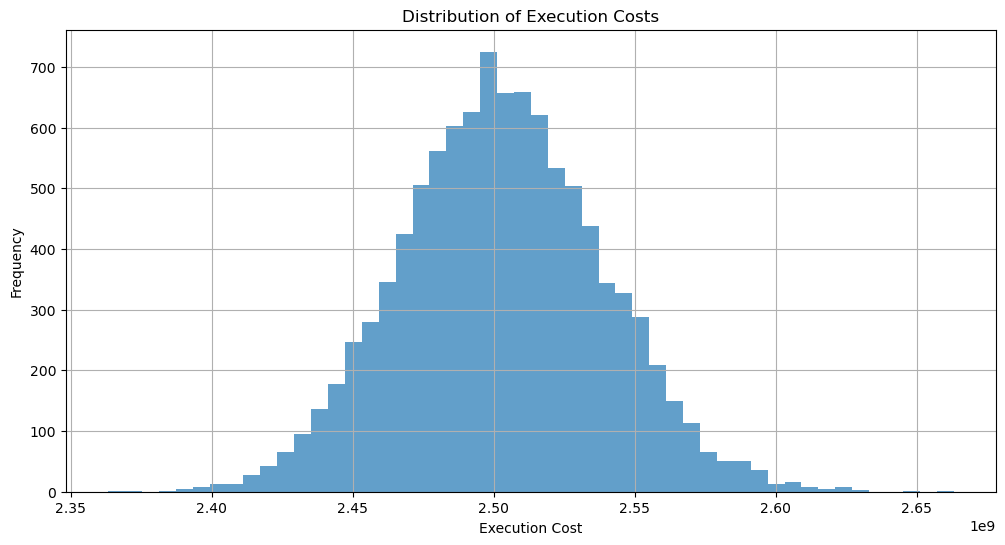

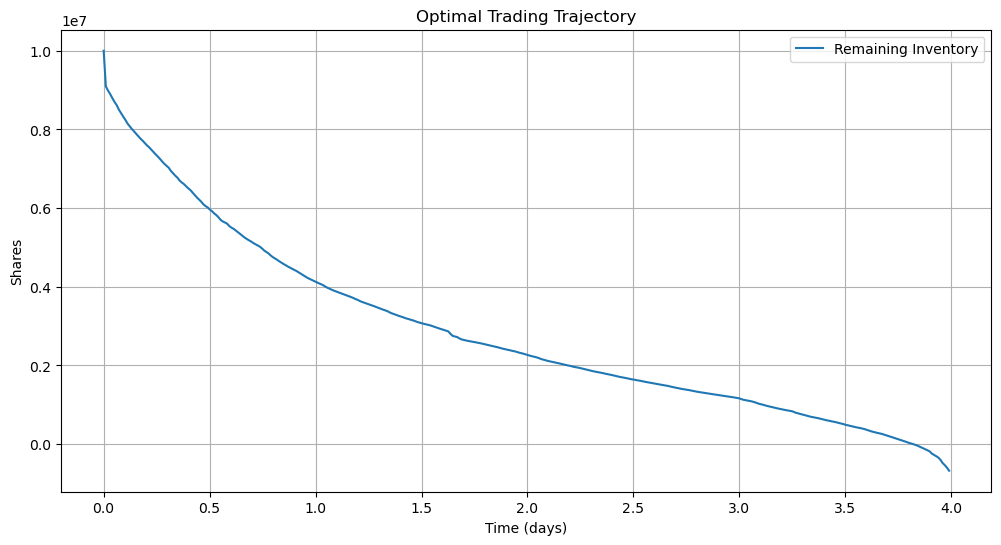

In [25]:
if __name__ == "__main__":
    main()
